<a href="https://colab.research.google.com/github/asheta66/Generative-AI-2/blob/main/C_Class_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [3]:
# # Install LaTeX
# !sudo apt-get update -y
# !sudo apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !sudo apt-get install -y texlive-xetex texlive-fonts-extra

In [4]:
# # !pip uninstall -y pandas tensorflow
# !pip install pandas tensorflow
# !pip install seaborn

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

from PIL import Image

# Function to get the size of the first image in the directory
def get_image_size(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                first_image_path = os.path.join(root, file)
                with Image.open(first_image_path) as img:
                    return img.size  # Returns (width, height)
    raise FileNotFoundError("No image files found in the directory.")

# Set the directory for the data stored on Google Drive
data_dir = '/content/drive/My Drive/BrainTumor/256x256'

# Automatically determine image size
try:
    img_size = get_image_size(data_dir)
    batch_size = 128
    print(f"Image size set to: {img_size}")
except FileNotFoundError as e:
    print(e)

# Set up data generators for training and validation with 20% validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='input', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='input', subset='validation')

# Determine the number of classes from the data generator
num_classes = len(train_generator.class_indices)

print("")
# Display the names of the classes and the number of images in each class
print("Class Names and Number of Images:")
for class_name, index in train_generator.class_indices.items():
    num_images = len(os.listdir(os.path.join(data_dir, class_name)))
    print("")
    print(f"{class_name}: {num_images} images")


Mounted at /content/drive
Image size set to: (256, 256)
Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.

Class Names and Number of Images:

glioma: 1426 images

meningioma: 708 images

pituitary tumor: 930 images


**Define the Autoencoder model structure**

In [6]:
# Define the Autoencoder model structure
input_img = Input(shape=(img_size[0], img_size[1], 3))

# Encoder part
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)

# Decoder part
x = Dense(128, activation='relu')(encoded)
x = Dense(256, activation='relu')(x)
x = Dense(img_size[0] * img_size[1] * 3, activation='sigmoid')(x)
decoded = Reshape((img_size[0], img_size[1], 3))(x)

# Compile the Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder model
history = autoencoder.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 526s 18s/step - loss: 0.0416 - val_loss: 0.0097
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - loss: 0.0089 - val_loss: 0.0080
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - loss: 0.0077 - val_loss: 0.0069
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0069 - val_loss: 0.0066
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0067 - val_loss: 0.0063
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - loss: 0.0065 - val_loss: 0.0061
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - loss: 0.0063 - val_loss: 0.0060
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.0062 - val_loss: 0.0058
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - loss: 0.0060 - val_loss: 0.0056


**Extract the encoder part of the Autoencoder for feature extraction and  build a classifier**

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Extract the encoder part of the Autoencoder for feature extraction
encoder = Model(inputs=input_img, outputs=encoded)

# Generate encoded features for training and validation data
train_features = encoder.predict(train_generator)
val_features = encoder.predict(val_generator)

# Get the corresponding labels and encode them into integer format
train_labels = train_generator.classes
val_labels = val_generator.classes

# Initialize and train the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(train_features, train_labels)

# Evaluate the classifier using the training data
train_predictions = decision_tree_classifier.predict(train_features)
train_labels_original = train_labels  # No need to convert to one-hot encoding for decision tree

# Evaluate the classifier using the validation data
val_predictions = decision_tree_classifier.predict(val_features)
val_labels_original = val_labels  # No need to convert to one-hot encoding for decision tree


20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


**Display Results**

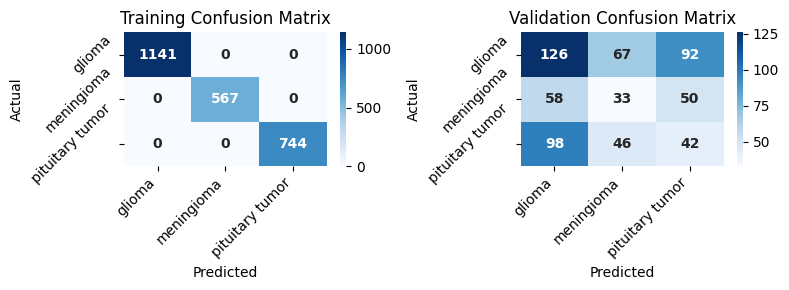

In [34]:
# Display confusion matrices and classification reports
conf_matrix_train = confusion_matrix(train_labels_original, train_predictions)
conf_matrix_val = confusion_matrix(val_labels_original, val_predictions)

plt.figure(figsize=(8, 3))

# Plot training confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys(),
            annot_kws={"size": 10, "weight": "bold"})  # Annotation properties
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=45, ha='right')  # Rotate y-axis labels

# Plot validation confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys(),
            annot_kws={"size": 10, "weight": "bold"})  # Annotation properties
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=45, ha='right')  # Rotate y-axis labels

plt.tight_layout()

# Save the figure to a file
plt.savefig('/content/confusion_matrices.png')

plt.show()

**Calculate and print performance metrics for the training data**

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate and print performance metrics for the training data
train_accuracy = accuracy_score(train_labels_original, train_predictions)
train_precision = precision_score(train_labels_original, train_predictions, average='weighted')
train_recall = recall_score(train_labels_original, train_predictions, average='weighted')
train_f1 = f1_score(train_labels_original, train_predictions, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print()

# Calculate and print performance metrics for the validation data
val_accuracy = accuracy_score(val_labels_original, val_predictions)
val_precision = precision_score(val_labels_original, val_predictions, average='weighted')
val_recall = recall_score(val_labels_original, val_predictions, average='weighted')
val_f1 = f1_score(val_labels_original, val_predictions, average='weighted')

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print()

# Print classification reports
print("Training Classification Report:")
print(classification_report(train_labels_original, train_predictions, target_names=train_generator.class_indices.keys()))

print("Validation Classification Report:")
print(classification_report(val_labels_original, val_predictions, target_names=val_generator.class_indices.keys()))

Training Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Validation Metrics:
Accuracy: 0.3284
Precision: 0.3295
Recall: 0.3284
F1 Score: 0.3290

Training Classification Report:
                 precision    recall  f1-score   support

         glioma       1.00      1.00      1.00      1141
     meningioma       1.00      1.00      1.00       567
pituitary tumor       1.00      1.00      1.00       744

       accuracy                           1.00      2452
      macro avg       1.00      1.00      1.00      2452
   weighted avg       1.00      1.00      1.00      2452

Validation Classification Report:
                 precision    recall  f1-score   support

         glioma       0.45      0.44      0.44       285
     meningioma       0.23      0.23      0.23       141
pituitary tumor       0.23      0.23      0.23       186

       accuracy                           0.33       612
      macro avg       0.30      0.30      0.30       612
   weighted av

**Plot Training and Validation Loss for Autoencoder and Classifier Accuracy**

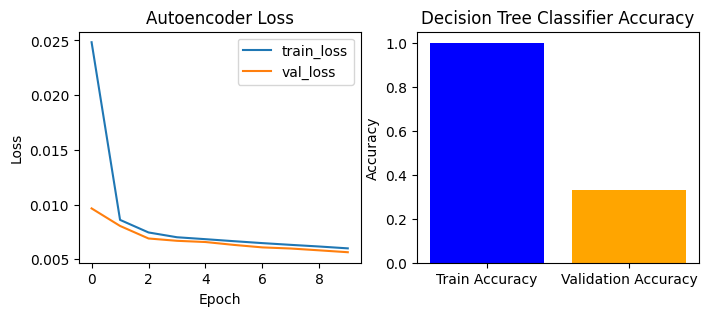

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Plot Training and Validation Loss for Autoencoder and Classifier Accuracy
plt.figure(figsize=(8,3))

# Autoencoder Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.legend()

# Calculate accuracy for training and validation data
train_accuracy = accuracy_score(train_labels_original, train_predictions)
val_accuracy = accuracy_score(val_labels_original, val_predictions)

# Since we don't have epochs for the Decision Tree classifier, we'll plot a bar chart instead
plt.subplot(1, 2, 2)
accuracy_values = [train_accuracy, val_accuracy]
labels = ['Train Accuracy', 'Validation Accuracy']
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Decision Tree Classifier Accuracy')

plt.show()


**Plot 6 random images (1 from each class) in a 2x3 grid**

Found 1141 images belonging to 1 classes.
Found 567 images belonging to 1 classes.
Found 744 images belonging to 1 classes.


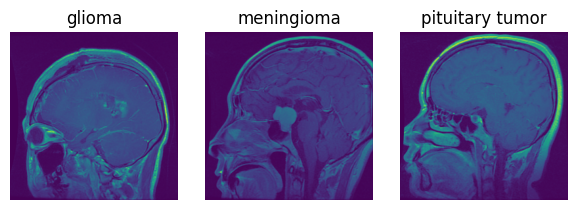

In [36]:
import numpy as np

# Plot 6 random images (1 from each class) in a 2x3 grid
plt.figure(figsize=(6, 4))
class_names = list(train_generator.class_indices.keys())
num_samples_per_class = 1  # Select 1 random image per class

for i, class_name in enumerate(class_names):
    # Fetch a batch of images for the current class
    class_images, _ = next(datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=100,  # Ensure batch size is large enough to include random images
        class_mode='input',
        subset='training',
        shuffle=True,
        classes=[class_name]
    ))

    # Select a random image from the batch
    random_index = np.random.randint(0, class_images.shape[0])
    image = class_images[random_index]

    # Plot the random image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(class_name)

plt.tight_layout()
plt.show()
